# Restrained Thompson Problem

See https://en.wikipedia.org/wiki/Thomson_problem


My solution to solve the Thompson problem in a cone involves two steps:

    1) Solve the problem on the uni sphere $S^2$
    2) Map the solution into the cone of axis $\vec{V}$ and aperture $2\Phi$

The first step is implemented in the function `run_sfdp` and uses the
[SFDP algorithm](http://yifanhu.net/PUB/graph_draw.pdf) on a star graph
containing N+1 nodes. After running the SFDP algorithm, the central node
is removed and the graph is centered and rescaled to the unit sphere.

The second step is implemented in the function `map_solution`, which
rotates each point $\vec{P}$ around the axis $\vec{P} \times \vec{V}$ by
an angle $\varphi = \frac{\Phi}{\pi} \arccos(\vec{P}\cdot\vec{V})$.

In [1]:
using Distances
using GeometryBasics
using LightGraphs
using LinearAlgebra
using NetworkLayout:SFDP
using Plots
using Random
using Rotations
using Statistics

In [2]:
# Initialize the random number generator to allow reproducibility
Random.seed!(1234)
# Use PyPlot as a plotting backend
pyplot()

Plots.PyPlotBackend()

In [44]:
# Number of directions to generate.
# Note: this method will try to produce at least N different directions
#       but it may produce slightly more.
N = 21

# Define the cone in which the N directions should lie
# V is a unit vector defining the axis of the cone,
# 2Φ is the aperture of the cone. 
V_sph = [0.0, π/2]  # Cone axis in spherical coordinates [φ, θ]
V = [sin(V_sph[2])*cos(V_sph[1]), sin(V_sph[2])*sin(V_sph[1]), cos(V_sph[2])]
Φ = abs(deg2rad(30))    # 1/2 the cone aperture (in rad)

# Define the tolerance of the SFDP algorithm.
# The smaller the tolerance, the harder the algorithm tries to
# find a good solution.
TOL = 1e-18

# Limit the maximum number of iterations for the SFDP algorithm
ITERATIONS = 20_000

20000

In [4]:
""" Convert cartesian to unit spherical coordinates.
The function takes a Nx3 matrix containing rows of points in cartesian
coordinates and returns a Nx2 matrix containing rows of points [φ, θ]
on the unit sphere S².
"""
function cart2sph(v::AbstractMatrix)
    x, y, z = @views v[:,1], v[:,2], v[:,3]
    r = sqrt.(x.^2 + y.^2 + z.^2)
    hcat(atan.(y, x), acos.(z./r))
end

""" Convert unit spherical to cartesian coordinates.
The function takes a Nx2 matrix containing rows of points [φ, θ]
on the unit sphere S² and returns a Nx3 matrix containing rows of
points in cartesian coordinates  .
"""
function sph2cart(v::AbstractMatrix)
    if size(v, 2) == 2
        r, φ, θ = ones(size(v, 1)), v[:,1], v[:,2]
    else
        r, φ, θ = v[:,1], v[:,2], v[:,3]
    end
    hcat(r.*sin.(θ).*cos.(φ), r.*sin.(θ).*sin.(φ), r.*cos.(θ))
end

sph2cart

In [5]:
""" Run the SFDP algorithm on a N+1 star graph, remove the central node,
center and rescale the graph representation to the unit sphere and return
a Nx3 matrix containing the points in cartesian coordinates. 
"""
function run_sfdp(len=N)
    g = StarGraph(len+1)
    a = adjacency_matrix(g)
    network = SFDP.layout(a, SFDP.Point{3,Float64}, tol=TOL, C=1, K=1, iterations=ITERATIONS)

    offset = sum(network)/length(network)
    network .-= offset
    sort!(network, by=norm)
    deleteat!(network, 1)
    network ./= norm.(network)

    X_cart = transpose(hcat(Array.(network)...))
end

run_sfdp

In [6]:
""" Rotate all points in the Nx3 matrix `n` so that the first point n[1,:]
aligns with the vector V.
Note1: this assumes that all vectors are normalized!
Note2: this function modifies the matrix `n` inplace.
"""
function rotate_solution!(n, V)
    rot_axis = V × n[1,:]
    rot_angle = -acos(V ⋅ n[1,:])
    R0 = AngleAxis(rot_angle, rot_axis...)
    for i in 1:size(n,1)
        n[i,:] .= R0*n[i,:]
    end
    n
end

rotate_solution!

In [46]:
""" Map the points in the Nx3 matrix `n` from the whole unit sphere S²
to the cone defined by V,phi.
"""
function map_solution(n, V, phi)
    m = zero(n)
    for i in 1:size(n,1)
        rot_axis = V × n[i,:]
        ang = acos(clamp.(V ⋅ n[i,:], -1.0, 1.0))
        new_ang = ang/π*phi
        rot_angle = new_ang-ang
        R = AngleAxis(rot_angle, rot_axis...)
        m[i,:] .= R*n[i,:]
    end
    m
end

map_solution

In [52]:
""" Analyze the quality of the solution and print some statistics.
Also create a histogram of the angles between each point and the cone axis.
"""
function check_solution(n, V, Φ)
    println("Checking solution:")
    println()

    t = all([norm(n[i, :]) ≈ 1.0 for i in 1:size(n,1)])
    println("Is on Sphere: $(t)")
    t = all([acos(n[i, :]⋅V/norm(n[i, :])) .<= Φ for i in 1:size(n,1)])
    println("Is inside cone: $(t)")
    d = rad2deg.(asin.(pairwise(Euclidean(), n, dims=1)./2.0).*2)
    d[diagind(d)] .= Inf
    d = reshape(minimum(d, dims=1), :)

    println("Angle between nearest neighbors (in deg):")
    println("  - Mean   = $(mean(d))")
    println("  - Std    = $(std(d)) ($(std(d)/median(d)*100.0) %)")
    println("  - Var    = $(var(d))")
    println("  - Max    = $(maximum(d))")
    println("  - Min    = $(minimum(d))")
    println("  - Median = $(median(d))")

    vm = mean(n, dims=(1,))
    vm ./= norm(vm)
    println("Angle between center of mass and cone axis V: Δϕ = $(rad2deg(acos(vm⋅V))) deg")

    # Create the histogram
    for i in 1:size(d,1)
        d[i] = rad2deg(acos(clamp(n[i,:]⋅V, -1.0, 1.0)))
    end
    return histogram(d, bins=15, label=false, xaxis=("∠(p, V) (deg)"), yaxis="Counts")
end

check_solution

==== SFDP ====

Checking solution:

Is on Sphere: true
Is inside cone: false
Angle between nearest neighbors (in deg):
  - Mean   = 45.14891476712686
  - Std    = 1.3018737931030082 (2.9230912254720605 %)
  - Var    = 1.6948753731684143
  - Max    = 48.635412472536586
  - Min    = 43.88727817239688
  - Median = 44.537569739814195
Angle between center of mass and cone axis V: Δϕ = 11.248432107305986 deg

==== SFDP (mapped) ====

Checking solution:

Is on Sphere: true
Is inside cone: true
Angle between nearest neighbors (in deg):
  - Mean   = 8.116519473079691
  - Std    = 0.5864055441022573 (7.485269250438803 %)
  - Var    = 0.34387146215386444
  - Max    = 9.384249102899537
  - Min    = 7.412021756842614
  - Median = 7.834127597586165
Angle between center of mass and cone axis V: Δϕ = 0.9704035418184445 deg


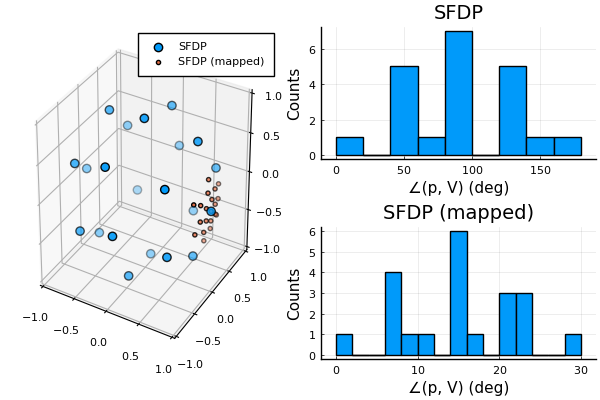

In [53]:
function solve()
    plt1 = plot(xaxis=((-1,1),), yaxis=((-1,1),), zaxis=((-1,1),), reuse=false)

    println("==== SFDP ====")
    println()

    n = run_sfdp(N)
    rotate_solution!(n, V)
    h1 = check_solution(n, V, Φ)

    println()
    println("==== SFDP (mapped) ====")
    println()

    m = map_solution(n, V, Φ)
    h2 = check_solution(m, V, Φ)

    plot!(plt1, n[:, 1], n[:, 2], n[:, 3], l=0, m=6, label="SFDP")
    plot!(plt1, m[:, 1], m[:, 2], m[:, 3], l=0, m=3, label="SFDP (mapped)")

    layout = @layout [
        a{} Plots.grid(2,1)
    ]

    p = plot(plt1, h1, h2, layout=layout, title=["" "SFDP" "SFDP (mapped)"])
end
solve()